In [1]:
!date

Fri 11 Sep 2020 15:34:24 EDT


In [2]:
import pandas as pd
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/Users/chuck/anaconda3/envs/py37-tensor/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# Step 1 - Load Existing Data

In [3]:
df_sars = pd.read_csv('./sample-data-whole-year-sars.csv', index_col=0, parse_dates = True)
df_sars.head()

,s_tin_t,a_t_heat,a_t_cool,s_tin_t+1,s_tout_t,r_discomfort_t,s_heat_stp_delta_t,s_cool_stp_delta_t,s_heat_stp_delta_t+1,s_cool_stp_delta_t+1,r_t+1,a_t
2017-01-01 00:15:00,20.1,1,0,20.5,-4,-2.094047,-1.0,-2.2,-0.6,-1.7,-2.122408,3
2017-01-01 00:20:00,20.5,1,0,21.2,-6,-1.122408,-0.6,-1.7,0.1,-1.0,-1.000000,3
2017-01-01 00:25:00,21.2,0,0,21.1,-6,-0.000000,0.1,-1.0,-0.0,-1.1,-0.077604,1
2017-01-01 00:30:00,21.1,0,0,20.7,-6,-0.077604,-0.0,-1.1,-0.4,-1.5,-0.844826,1
2017-01-01 00:35:00,20.7,0,0,19.9,-6,-0.844826,-0.4,-1.5,-1.2,-2.3,-2.344889,1


## Context

**state = (s_heat_stp_delta_t, s_cool_stp_delta_t)**

which are the differences between th setpoints and the indoor air temperature

**action = a_t**

which is off, cooling, heating enumerated as 1,2,3

**rewared = r_t+1** 

which is the combination of needing to use runtime (a = 2 or 3) and discomfort thermally from the next state 

In [4]:
# build the training set
df_training = df_sars['2017-01-01':'2017-01-15']
print(df_training.shape)

(4317, 12)


Text(0, 0.5, 'count')

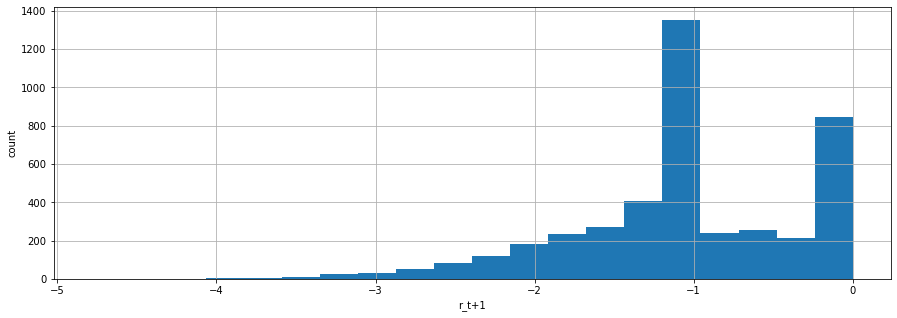

In [5]:
df_training['r_t+1'].hist(bins=20, figsize=(15,5))
plt.xlabel('r_t+1')
plt.ylabel('count')

In [6]:
# which states did we see in this training period.
# note - state 2 not observed (makes sense this is cooling)
df_training['a_t'].value_counts()

1    2548
3    1769
Name: a_t, dtype: int64

# Step 2 - Initalize the DQN stuff

In [7]:
import random
import os
import numpy as np
from collections import deque

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [77]:
class Agent():
    def __init__(self, state_size, action_size, verbose=True):
        self.state_size = state_size
        self.action_size = action_size
        
        # get the architecture
        self.max_memory = 20000
        self.memory = deque(maxlen=self.max_memory)
        
        self.learning_rate = 0.001
        self.gamma = 0.95
        self.epochs=1
        self.batch_size=32
        
        self.reset(verbose)
        

    def _build_model(self,verbose):
         
        # set up the neural network as the function approximator
        model = Sequential()
        regularizer = l2(1e-6)
        model.add(Dense(units=12, input_dim=self.state_size,
                    kernel_regularizer=regularizer))
        model.add(LeakyReLU())
        model.add(Dense(units=12,
                    kernel_regularizer=regularizer))
        model.add(LeakyReLU())
        model.add(Dense(units=self.action_size,
                    activation='linear',
                    kernel_regularizer=regularizer))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        if verbose:
            print(model.summary())
        return model

    def backup(self, reward, new_state, _, done):
        if done:
            return reward 
        else:
            return reward + self.gamma * np.amax(self.values(new_state))

    def values(self, state):
        return self.model.predict(state)[0]

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):

        # we don't have enough memory for training
        batch_size = self.batch_size
        if len(self.memory) < self.batch_size:
            return

        # sample a minibatch
        state_size = self.state_size
        mini_batch = random.sample(self.memory, batch_size)
        states = np.zeros((batch_size, state_size), dtype=float)
        next_states = np.zeros((batch_size, state_size), dtype=float)
        for i, memory in enumerate(mini_batch):
            state, _, _, new_state, _ = memory
            states[i] = state
            next_states[i] = new_state

        # make the predictions with current models
        values = self.model.predict(states)
        next_values = self.model.predict(next_states)

        # update model weights based on error in prediction
        gamma = self.gamma
        for i, memory in enumerate(mini_batch):
            _, action, reward, _, done = memory
            values[i][action] = reward
            if not done:
                values[i][action] += gamma * np.amax(next_values[i])

        # make batch which includes target q value and predicted q value
        history = self.model.fit(states, values,
                       batch_size=batch_size,
                       epochs=self.epochs,
                       verbose=0)
        return history

    def reset(self,verbose):
        self.memory = deque(maxlen=self.max_memory)
        self.model = self._build_model(verbose)

In [89]:
state_size = 2
action_size = 3
agent = Agent(state_size, action_size)


Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 12)                36        
_________________________________________________________________
leaky_re_lu_98 (LeakyReLU)   (None, 12)                0         
_________________________________________________________________
dense_147 (Dense)            (None, 12)                156       
_________________________________________________________________
leaky_re_lu_99 (LeakyReLU)   (None, 12)                0         
_________________________________________________________________
dense_148 (Dense)            (None, 3)                 39        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________
None


### Step 2a - load up the buffer

In [90]:
# fill up the buffer
for index, row in df_training.iterrows():
    
    state = np.array([row['s_heat_stp_delta_t'],row['s_cool_stp_delta_t']])
    action =  int(row['a_t']-1)
    reward = row['r_t+1']
    next_state = np.array([row['s_heat_stp_delta_t+1'],row['s_cool_stp_delta_t+1']])
    done = False
    
    # Clip all positive rewards at 1 and all negative rewards at -1, leaving 0 rewards unchanged
    # reward = np.clip(reward, -1, 1)
    
    agent.remember(state, action, reward, next_state, done)

### Step 2b - train the model

In [91]:
sample_batch_size = 32
episodes = 150

loss_list = []
# run N episodes of a certain batch size
for _ in range(episodes):
    history = agent.train()
    loss_list.append(history.history['loss'])

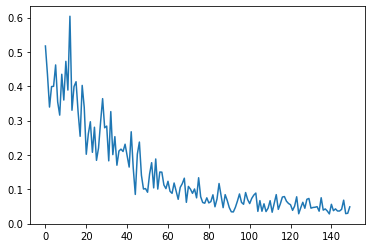

In [92]:
plt.plot(loss_list)

# Step 3 - Predcition back over the test

In [84]:
def _choose_action_based_on_q_vals(vals:np.array)->int:
    return np.argmax(vals)

def _choose_action_based_on_q_vals_with_filter(vals:np.array)->int:
    "getting some unwanted postive values for actions so filter out befor selecting"
    try:
        index_val = np.where(vals == vals[vals <= 0].max())[0][0]
    except ValueError:
        index_val = -1
    return index_val


In [85]:
for row, data in df_training.iterrows():
    input_vals =  np.array([data["s_heat_stp_delta_t"], data["s_cool_stp_delta_t"]]).reshape(-1,2)
    q_vals = agent.model.predict(input_vals)
    best_val = _choose_action_based_on_q_vals(q_vals[0])
    df_training.at[row,'q_decision'] = best_val + 1
    
    best_val_filt = _choose_action_based_on_q_vals_with_filter(q_vals[0])
    df_training.at[row,'q_decision_wfilt'] = best_val_filt + 1

In [86]:
df_training['q_decision'].value_counts()

2.0    4051
1.0     266
Name: q_decision, dtype: int64

In [87]:
df_training['q_decision_wfilt'].value_counts()

1.0    2568
3.0    1742
2.0       7
Name: q_decision_wfilt, dtype: int64

In [88]:
df_training['a_t'].value_counts()

1    2548
3    1769
Name: a_t, dtype: int64

#### Notes

- would have hoped the q_decisions would match the deadband controls which generated the logged data but that doesnt seem to be happening
- the fact that action 2 (cooling) is being selected is also troubling. This would never have been observed in training as it was trained using data from January. 

### Part 3a - how does this look around the whole year?

In [99]:
def load_buffer(buffer, train_data:pd.DataFrame):
    # fill up the buffer
    for index, row in train_data.iterrows():
        state = np.array([row['s_heat_stp_delta_t'],row['s_cool_stp_delta_t']])
        action =  int(row['a_t']-1)
        reward = row['r_t+1']
        next_state = np.array([row['s_heat_stp_delta_t+1'],row['s_cool_stp_delta_t+1']])
        done = False

        # Clip all positive rewards at 1 and all negative rewards at -1, leaving 0 rewards unchanged
        # reward = np.clip(reward, -1, 1)
        buffer.remember(state, action, reward, next_state, done)

def predict_back_on_train(train_data:pd.DataFrame, policy_net:Agent):
    for row, _data in train_data.iterrows():
        input_vals =  np.array([data["s_heat_stp_delta_t"], data["s_cool_stp_delta_t"]]).reshape(-1,2)
        q_vals = policy_net.model.predict(input_vals)
        
        best_val = _choose_action_based_on_q_vals(q_vals[0])
        train_data.at[row,'q_decision'] = best_val + 1

        best_val_filt = _choose_action_based_on_q_vals_with_filter(q_vals[0])
        train_data.at[row,'q_decision_wfilt'] = best_val_filt + 1
    
        
def _sliding_q_table_training(df: pd.DataFrame):
    hold_dfs = {}
    loss = {}
    for date, data in df.groupby(pd.Grouper(freq="SMS", label="right")):
        if data.shape[0] > 500:  # to clip some rollover
            dqn = Agent(state_size, action_size, False)
            load_buffer(dqn, data)
            loss_history = []
            for _ in range(episodes):
                history = dqn.train()
                loss_history.append(history.history['loss'])
                
            predict_back_on_train(data, dqn)
            hold_dfs[date] = data.copy()
            loss[date] = loss_history
        print("Done", date)
    return hold_dfs, loss

In [100]:
# warning this is slow...
result_dict, loss_dict = _sliding_q_table_training(df_sars)

Done 2017-01-15 00:00:00
Done 2017-02-01 00:00:00
Done 2017-02-15 00:00:00
Done 2017-03-01 00:00:00
Done 2017-03-15 00:00:00
Done 2017-04-01 00:00:00
Done 2017-04-15 00:00:00
Done 2017-05-01 00:00:00
Done 2017-05-15 00:00:00
Done 2017-06-01 00:00:00
Done 2017-06-15 00:00:00
Done 2017-07-01 00:00:00
Done 2017-07-15 00:00:00
Done 2017-08-01 00:00:00
Done 2017-08-15 00:00:00
Done 2017-09-01 00:00:00
Done 2017-09-15 00:00:00
Done 2017-10-01 00:00:00
Done 2017-10-15 00:00:00
Done 2017-11-01 00:00:00
Done 2017-11-15 00:00:00
Done 2017-12-01 00:00:00
Done 2017-12-15 00:00:00
Done 2018-01-01 00:00:00
Done 2018-01-15 00:00:00


Text(0.5, 0.98, 'Predict back on training data')

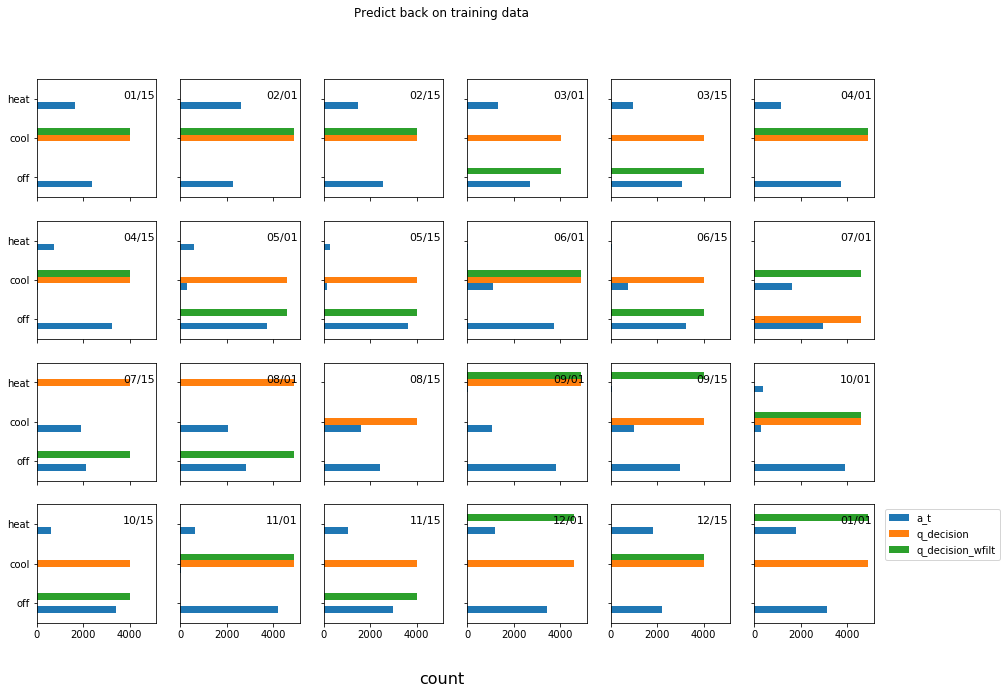

In [101]:
fig, ax = plt.subplots(4,6,figsize=(15,10), sharex=True, sharey=True)
flat_ax = ax.flatten()
for i, (key, value) in enumerate(result_dict.items()):
    df_temp = pd.DataFrame(index=[1,2,3])
    df_temp = df_temp.join(value['a_t'].value_counts()).join(value['q_decision'].value_counts()).join(value['q_decision_wfilt'].value_counts()).fillna(0)
    df_temp.plot(kind='barh', ax=flat_ax[i], legend=False)
    flat_ax[i].set_yticklabels(['off','cool','heat'])
    flat_ax[i].text(3700,2,key.strftime("%m/%d"),fontsize=11)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.text(0.5, 0.04, 'count', ha='center', fontsize=16)
plt.suptitle('Predict back on training data')

No handles with labels found to put in legend.


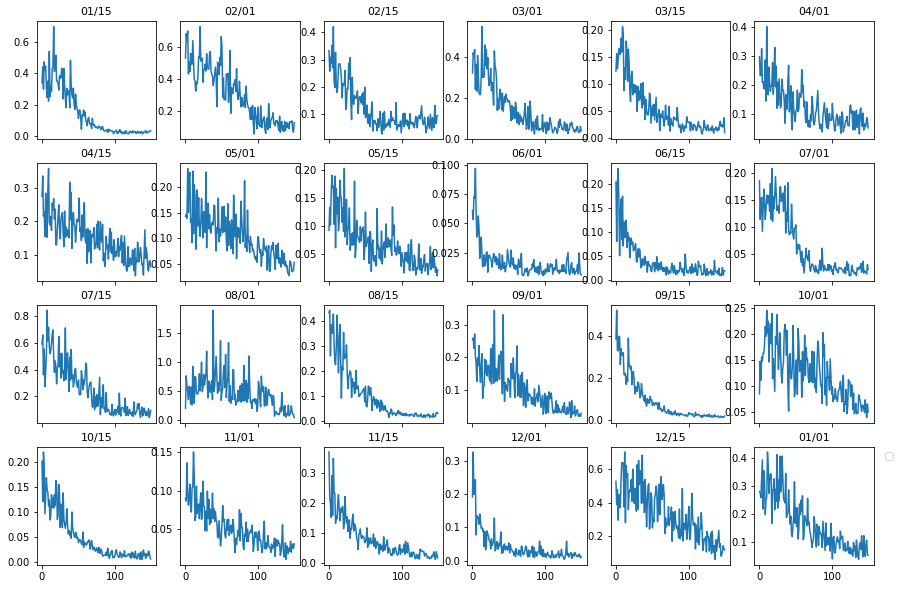

In [108]:
fig, ax = plt.subplots(4,6,figsize=(15,10), sharex=True, sharey=False)
flat_ax = ax.flatten()
for i, (key, value) in enumerate(loss_dict.items()):
   
    flat_ax[i].plot(value)

    flat_ax[i].set_title(key.strftime("%m/%d"),fontsize=11)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#fig.text(0.5, 0.04, 'count', ha='center', fontsize=16)
#plt.suptitle('Predict back on training data')